The data for this example are about 10 years of hourly water level and meteorological measurments from the NOAA station at Scripps in La Jolla (details are at the end).

This shows how to wrangle semi-messy real-world data from the NOAA CSV files into a tidy `pandas.DataFrame` of time-stamped epochs ready to load into `fitgrid.Epochs` for modeling. 

The steps are:

1. Groom and merge NOAA ocean water level and atmospheric hourly time series observations into a `pandas.DataFrame`.
2. Add a column of event tags that mark the `high_tide` time-locking events of interest.
3. Snip the time-series apart into fixed length epochs and construct a new column of time-stamps in each epoch with the `high_tide` event of interest at time=0.
4. Export the epochs data frame to save for later use in `fitgrid`

In [12]:
from pathlib import Path
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from matplotlib import pyplot as plt
plt.style.use("seaborn-bright")
rc_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import fitgrid as fg
from fitgrid import DATA_DIR

register_matplotlib_converters()  # to supress datetime FutureWarning

np.random.seed(512)  # to freeze examples

# path to hourly water level and meteorology data
WDIR = DATA_DIR / "CO-OPS_9410230"

# `tides`: hourly water level measurements

Notes:

* the original `date` and `time_(gmt)` columns are formed into a `pandas.Datetime` which will serve as the index for merging the meteorological observations.

* there are missing observations, these are coded `NaN`

In [15]:
# read and tidy up the NOAA water level CSVs
tides = pd.concat(
    [
        pd.read_csv(tide_f, na_values='-')
        for tide_f 
        in WDIR.glob('*msl_wl.csv')
    ]
).drop(["Predicted (ft)", "Preliminary (ft)"], axis=1)

# sanitize the column names
tides.columns = [col.lower().replace(" ", "_") for col in tides.columns]

# make gmt date times usable
tides['date_time_gmt'] = pd.to_datetime(
        tides['date'] + ' ' + tides["time_(gmt)"]
    )

# add local time at Scripps from the GMT
tides.insert(
    1,
    'hour_pst', 
   (tides['date_time_gmt'] + pd.Timedelta(hours=-8)).dt.time.astype(str)
)


# drop unused columns
tides = (
    tides
    .sort_values('date_time_gmt')
    .drop(['date', 'time_(gmt)'], axis=1)
)

tides.rename(columns={"verified_(ft)": "water_level"},inplace=True)

tides.set_index("date_time_gmt", inplace=True)
tides

,hour_pst,water_level
date_time_gmt,,
2010-08-01 00:00:00,16:00:00,-0.19
2010-08-01 01:00:00,17:00:00,-0.65
2010-08-01 02:00:00,18:00:00,-0.91
2010-08-01 03:00:00,19:00:00,-0.86
2010-08-01 04:00:00,20:00:00,-0.60
...,...,...
2020-07-31 19:00:00,11:00:00,NaN
2020-07-31 20:00:00,12:00:00,NaN
2020-07-31 21:00:00,13:00:00,NaN


# `metobs`: hourly meteorological observations

In [16]:
metobs = pd.concat(
   [
        pd.read_csv(tide_f, na_values='-')
        for tide_f 
        in WDIR.glob('*met.csv')
    ]
)
metobs.columns = [
    col.strip().lower().replace(" ", "_")
    for col 
    in metobs.columns
]
metobs['date_time_gmt'] = pd.to_datetime(metobs.date_time)
metobs = metobs.drop(
    ["windspeed", "dir", "gusts", "relhum", "vis", "date_time"], 
    axis=1
)[["date_time_gmt", "baro", "at"]]

metobs.set_index("date_time_gmt", inplace=True)
metobs.rename(
    columns={
        "baro": "mm_hg",
        "at": "air_temp"
    }, 
    inplace=True
)
metobs

,mm_hg,air_temp
date_time_gmt,,
2018-08-01 01:00:00,NaN,NaN
2018-08-01 02:00:00,NaN,NaN
2018-08-01 03:00:00,NaN,NaN
2018-08-01 04:00:00,NaN,NaN
2018-08-01 05:00:00,NaN,NaN
...,...,...
2020-01-29 18:00:00,1016.4,60.4
2020-01-29 19:00:00,1015.9,58.3
2020-01-29 20:00:00,1015.0,57.2


# `data`: time-aligned tide and atmospheric observations

Here we merge the hourly tide and atmosphere observations on their date and time stamp.

`NaN` in either data set triggers exclusion of the entire row.

In [17]:
data = tides.join(metobs, on='date_time_gmt').dropna().reset_index()

# standardize observations
for col in ["water_level", "mm_hg", "air_temp"]:
    col_z = col + "_z"
    data[col + "_z"] = (data[col] - data[col].mean()) / data[col].std()
    
# add a column of standard normal noise
data["std_noise_z"] = np.random.normal(loc=-0, scale=1.0, size=len(data))

# Define Epoch time-locking events: `high_tide`


For this example the time-lock events are high tide, defined as local water-level maxima. Other time-lock events could be imagined: low-tide, high-to-low zero crossing etc..

Note that there are two high-tide events in each approximately 24 hour period.

In [21]:
# boolean vector True at water level local maxima , i.e., high tide
data['high_tide'] = (
    np.r_[
        False, 
        data.water_level_z[1:].to_numpy() > data.water_level_z[:-1].to_numpy()
    ] & 
    np.r_[
        data.water_level_z[:-1].to_numpy() > data.water_level_z[1:].to_numpy(), 
        False
    ]
)

# these are just the high tide rows
data[data['high_tide'] == True]

,date_time_gmt,hour_pst,water_level,mm_hg,air_temp,water_level_z,mm_hg_z,air_temp_z,std_noise_z,high_tide
2,2011-03-13 02:00:00,18:00:00,0.00,1018.5,56.8,-0.108422,0.939952,-1.096733,-1.573892,True
5,2011-03-13 05:00:00,21:00:00,0.10,1019.4,56.8,-0.046256,1.186141,-1.096733,-0.602190,True
10,2011-03-13 10:00:00,02:00:00,1.47,1019.7,55.6,0.805429,1.268204,-1.304730,0.808677,True
25,2011-03-14 01:00:00,17:00:00,-0.04,1020.8,57.7,-0.133289,1.569101,-0.940736,-0.430043,True
28,2011-03-14 04:00:00,20:00:00,0.04,1023.0,57.6,-0.083556,2.170896,-0.958069,-1.655447,True
...,...,...,...,...,...,...,...,...,...,...
65794,2019-12-29 18:00:00,10:00:00,2.89,1022.8,58.6,1.688197,2.116188,-0.784738,0.184646,True
65808,2019-12-30 08:00:00,00:00:00,1.18,1017.1,52.2,0.625145,0.556992,-1.894053,0.802972,True
65819,2019-12-30 19:00:00,11:00:00,2.58,1014.4,57.6,1.495480,-0.181574,-0.958069,0.855209,True
65833,2019-12-31 09:00:00,01:00:00,1.32,1012.7,54.9,0.712179,-0.646597,-1.426061,1.228899,True


# Define, extract, index, and timestamp each epoch

1. **Define the epoch interval** The epoch interval is given by a fixed number of observations. **All epochs have the same length.** Typically, the epoch interval spans observations before and after a "time-locking" event. The length of the interval and the location of the time locking event in the epoch interval depends on the research question. 

2. **Define the timestamps** Once the length of the epoch interval is determined, a sequence of integer timestamps is specified, one per observation in the epoch: **The sequence of timestamps must be the same in each epoch.**. Time stamps are typically constructed relative to the events of experimental interest at `time==0`. The units of the time stamps are up to the experimenter and can be on any scale as long as they are data type compatible with 64-bit integers.

3. **Define the epoch indexes** Each epoch must have a unique integer identifier. The epoch indexes **must be unique but need not be sequential**. The epoch indexes may become gappy if if data quality control knocks out epochs after they are initially indexes. The epochs can be reindexed but it is generally better to retain the original index, otherwise different epochs wind up with the same integer identifier at different points in the an analysis pipeline. 

> **Epoch overlap** Long epochs may span mulitiple time-lock events other than the one at `time==0`. This is fine except that epoch boundaries will overlap in the data time series ... the data in the tail of one epoch will also be included in the head of the next epoch. In extreme case of boundary overlap, "slicing" the original data into epochs can makes the epochs data larger than the original timeseries because of the tail-and-head data duplication.

In [24]:
# 6 hours before, to 24 hours after high tide.
# high tides occur about every 12 hours so the
# epochs overlap
pre, post = 3, 8 

hrs = list(range(0 - pre, post))  

n_obs = len(data)
ht_idxs = np.where(data.high_tide)[0]

# pre-compute epoch slice boundaries ... note these start-stop
# intervals may overlap in the original data
epoch_bounds = [
    (ht_idx - pre, ht_idx + post)
    for ht_idx in ht_idxs
    if ht_idx >= pre and ht_idx + post < n_obs
]

epochs = []
for start, stop in epoch_bounds:
    epoch = data.iloc[start:stop, :].copy()   # slice the epoch interval from the original data
    epoch['epoch_id'] = len(epochs)           # construct
    epoch['time'] = hrs
    epochs.append(epoch)

epochs_df = pd.concat(epochs).set_index(['epoch_id', 'time'])

In this example epochs are 11 hours long, the time locking event is high tide and occurs at 

In [7]:

with pd.option_context("display.max_rows", None):
    display(epochs_df[0:60])

date_time_gmt  hour_pst  water_level   mm_hg  air_temp  \
epoch_id time                                                                
0        -3   2011-03-13 02:00:00  18:00:00         0.00  1018.5      56.8   
         -2   2011-03-13 03:00:00  19:00:00        -0.26  1018.8      57.2   
         -1   2011-03-13 04:00:00  20:00:00         0.05  1019.1      57.0   
          0   2011-03-13 05:00:00  21:00:00         0.10  1019.4      56.8   
          1   2011-03-13 06:00:00  22:00:00         0.05  1019.7      56.7   
          2   2011-03-13 07:00:00  23:00:00         0.33  1019.8      55.8   
          3   2011-03-13 08:00:00  00:00:00         1.07  1019.7      55.9   
          4   2011-03-13 09:00:00  01:00:00         1.13  1019.7      56.1   
          5   2011-03-13 10:00:00  02:00:00         1.47  1019.7      55.6   
          6   2011-03-13 11:00:00  03:00:00         1.44  1019.3      55.4   
          7   2011-03-13 12:00:00  04:00:00         0.98  1019.5      55.2   
1        -3   2011-03-13 07:00:00  23:00:00         0.33  1019.8      55.8   
         -2   2011-03-13 08:00:00  00:00:00         1.07  1019.7      55.9   
         -1   2011-03-13 09:00:00  01:00:00         1.13  1019.7      56.1   
          0   2011-03-13 10:00:00  02:00:00         1.47  1019.7      55.6   
          1   2011-03-13 11:00:00  03:00:00         1.44  1019.3      55.4   
          2   2011-03-13 12:00:00  04:00:00         0.98  1019.5      55.2   
          3   2011-03-13 13:00:00  05:00:00         0.64  1020.3      55.0   
          4   2011-03-13 14:00:00  06:00:00        -0.21  1020.8      54.9   
          5   2011-03-13 15:00:00  07:00:00        -0.51  1021.4      54.7   
          6   2011-03-13 16:00:00  08:00:00        -1.26  1022.0      54.3   
          7   2011-03-13 17:00:00  09:00:00        -2.08  1022.5      54.5   
2        -3   2011-03-13 22:00:00  14:00:00        -1.50  1021.2      57.6   
         -2   2011-03-13 23:00:00  15:00:00        -0.86  1020.5      57.6   
         -1   2011-03-14 00:00:00  16:00:00        -0.28  1020.3      59.2   
          0   2011-03-14 01:00:00  17:00:00        -0.04  1020.8      57.7   
          1   2011-03-14 02:00:00  18:00:00        -0.25  1021.3      57.4   
          2   2011-03-14 03:00:00  19:00:00        -0.06  1022.4      57.9   
          3   2011-03-14 04:00:00  20:00:00         0.04  1023.0      57.6   
          4   2011-03-14 05:00:00  21:00:00        -0.29  1022.9      56.8   
          5   2011-03-14 06:00:00  22:00:00        -0.20  1023.0      55.9   
          6   2011-03-14 07:00:00  23:00:00        -0.10  1022.7      55.2   
          7   2011-03-14 08:00:00  00:00:00         0.14  1022.3      55.4   
3        -3   2011-03-14 01:00:00  17:00:00        -0.04  1020.8      57.7   
         -2   2011-03-14 02:00:00  18:00:00        -0.25  1021.3      57.4   
         -1   2011-03-14 03:00:00  19:00:00        -0.06  1022.4      57.9   
          0   2011-03-14 04:00:00  20:00:00         0.04  1023.0      57.6   
          1   2011-03-14 05:00:00  21:00:00        -0.29  1022.9      56.8   
          2   2011-03-14 06:00:00  22:00:00        -0.20  1023.0      55.9   
          3   2011-03-14 07:00:00  23:00:00        -0.10  1022.7      55.2   
          4   2011-03-14 08:00:00  00:00:00         0.14  1022.3      55.4   
          5   2011-03-14 09:00:00  01:00:00         0.56  1022.0      55.8   
          6   2011-03-14 10:00:00  02:00:00         0.99  1021.4      55.6   
          7   2011-03-14 11:00:00  03:00:00         1.26  1020.9      55.8   
4        -3   2011-03-14 09:00:00  01:00:00         0.56  1022.0      55.8   
         -2   2011-03-14 10:00:00  02:00:00         0.99  1021.4      55.6   
         -1   2011-03-14 11:00:00  03:00:00         1.26  1020.9      55.8   
          0   2011-03-14 12:00:00  04:00:00         1.41  1020.6      55.2   
          1   2011-03-14 13:00:00  05:00:00         1.13  1020.9      55.2   
          2   2011-03-14 14:00:00  06:00:0

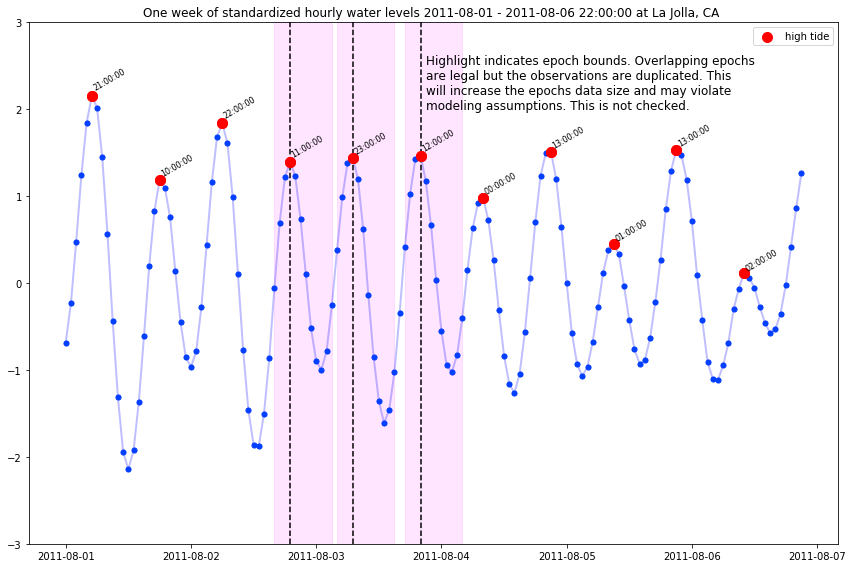

In [8]:
dt_start, dt_stop = '2011-08-01', '2011-08-06 22:00:00'
aug_01_07_11 = data.query(
    "date_time_gmt >= @dt_start and date_time_gmt < @dt_stop"
)
# display(aug_01_07_11)

f, ax = plt.subplots(figsize=(12,8))
ax.set(ylim=(-3, 3))
ax.plot(
    aug_01_07_11.date_time_gmt,
    aug_01_07_11.water_level_z,
    lw=2,
    alpha=.25,
    ls='-',
    marker='.',
    markersize=10,
    color='blue',
)

ax.plot(
    aug_01_07_11.date_time_gmt,
    aug_01_07_11.water_level_z,
    marker='.',
    markersize=10,
    lw=0
)

ax.scatter(
    aug_01_07_11.date_time_gmt[aug_01_07_11.high_tide == True],
    aug_01_07_11.water_level_z[aug_01_07_11.high_tide == True],
    color='red',
    s=100,
    zorder=3
    
)

ax.scatter(
    aug_01_07_11.date_time_gmt[aug_01_07_11.high_tide == True],
    aug_01_07_11.water_level_z[aug_01_07_11.high_tide == True],
    color='red',
    s=100,
    zorder=3,
    label="high tide"
    
)

for day, (_, ht) in enumerate(aug_01_07_11[aug_01_07_11.high_tide == True].iterrows()):
    txt = ax.annotate(
        str(ht.hour_pst),
        (ht.date_time_gmt, ht.water_level_z),
        (ht.date_time_gmt, ht.water_level_z * 1.02),
        ha='left',
        va='bottom',
        fontsize=8,
        rotation=30,
    )
    if day in [3, 4, 5]:
        ax.axvline(ht.date_time_gmt, color='black', ls="--")
        ax.axvspan(
            ht.date_time_gmt - pd.Timedelta(pre, 'h'),
            ht.date_time_gmt + pd.Timedelta(post, 'h'),
            color='magenta',
            alpha=0.1,
        )
        if day == 5:
            ax.annotate(
                xy=(ht.date_time_gmt + pd.Timedelta(hours=1), 2.),
                s=("Highlight indicates epoch bounds. Overlapping epochs\n"
                   "are legal but the observations are duplicated. This\n"
                   "will increase the epochs data size and may violate\n"
                   "modeling assumptions. This is not checked."
                ),
                size=12,            
            )


ax.set_title(f"One week of standardized hourly water levels {dt_start} - {dt_stop} at La Jolla, CA ");
ax.legend()
f.tight_layout()

# (optional) Export time series and epochs data for later use


In [9]:
# export tidied time series data 
data.to_hdf(DATA_DIR / "CO-OPS_9410230.h5", key="data", mode='w')

# export time-stamped epochs for loading into fitgrid.Epochs
epochs_df.to_hdf(DATA_DIR / "CO-OPS_9410230.h5", key="epochs_df", mode='a')

# Data source: NOAA Scripps Pier, La Jolla, CA

NOAA CO-OPS-9419230  
Station: La Jolla, CA 94102 (Scripps)  
August 1, 2010 - July 1, 2020


Ocean waterlevels measured hourly relative to mean sea level (MSL)

https://tidesandcurrents.noaa.gov/waterlevels.html?id=9410230&units=standard&timezone=GMT&action=data


Atmospheric meteorological observations:



https://tidesandcurrents.noaa.gov/met.html?id=9410230&units=standard&timezone=GMT&action=data


Additional information from NOAA:

* tide data option: https://tidesandcurrents.noaa.gov/datum_options.html

* NOAA Glossary: https://tidesandcurrents.noaa.gov/glossary.html

* General information: https://tidesandcurrents.noaa.gov/publications/Computational_Techniques_for_Tidal_Datums_handbook.pdf